# Project: Wrangling and Analyze Data
___

# Data Gathering

In [971]:
import pandas as pd

In [972]:
import gather # gathering functions module, shift+tab on each function call bellow for more details.

1. ~Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)~
___

### 2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

`gather.download_file_from_url(url_path='data/link.txt', destination='data/image_predictions.tsv')` **\*file already exists**

In [973]:
help(gather.download_file_from_url) # doc for the above function

Help on function download_file_from_url in module gather:

download_file_from_url(url_path, destination)
    Save File From a given url.
    
    :param url_path: (str) a path a file containing the url.
    :param destination: (str) a path to save the response at.



___

### 3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

**Archive data DataFrame:**

In [974]:
archive_original = pd.read_csv('data/twitter-archive-enhanced.csv', 
                               dtype={'tweet_id': pd.StringDtype()})
dump_lst = archive_original['tweet_id'] # to get list of id's as strings
archive_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   string 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**Auth object:** # SEE README

In [975]:
auth = gather.get_auth(auth_file='data/auth_blank.txt') # get authentication
auth_params = [auth.consumer_key, auth.consumer_secret, auth.access_token, auth.access_token_secret]
if not all(auth_params):
    print('To redownload or add data, please fill your API credentials (*without any spaces*) '\
    'at the empty auth file at "data/auth_blank.txt".')

To redownload or add data, please fill your API credentials (*without any spaces*) at the empty auth file at "data/auth_blank.txt".


**Dump function:**

`gather.dump_tweets_data(id_lst=dump_lst, auth=auth)` **\*takes about 30 min, file already exists.**
***NOTICE-loaded to json instead, relevant attributes only (rt and favorite counts):***

In [976]:
help(gather.dump_tweets_data) # doc for the above function

Help on function dump_tweets_data in module gather:

dump_tweets_data(id_lst, auth)
    Dump tweets' id, retweet count and favorite count into json file.
    
    :param id_lst: (list[str]) a list containing tweet id's.
    :param auth: (tweepy.auth.OAuth1UserHandler) an auth object.



___
### Additional DataFrames creation:

**Tweets' counts DataFrame:**

In [977]:
tweet_cnts = pd.read_json('data/tweets_data.json', dtype={'id': pd.StringDtype()})
tweet_cnts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2356 non-null   string 
 1   favorite_count  2326 non-null   float64
 2   retweet_count   2326 non-null   float64
dtypes: float64(2), string(1)
memory usage: 55.3 KB


**image predictions DataFrame:** 

In [978]:
img_preds = pd.read_csv('data/image_predictions.tsv', sep='\t', 
                        dtype={'tweet_id': pd.StringDtype()})
img_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   string 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4), string(1)
memory usage: 152.1+ KB


---

# Assessing Data

### Total quality issues - <mark> 8 </mark>
### Total tidiness issues - <mark> 4 </mark>

## **`archive_original` issues:**
### Quality issues - <mark> 7 </mark>
- *completeness*
    - missing tweet links urls in `expanded_urls` data, even in non empty cells. Detected visually - `archive_original.iloc[313]`, `archive_original.iloc[35]`
    - because we would like to clearly see if the relevant id is an original tweet, a boolean column
    `is_original` should be included.
    - because we would like to clearly see if the relevant id is a reply, a boolean column `is_reply` should be included.
- *validity* - 
    - inappropriate data type for columns `in_reply_to_status_id`,                   
    `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`: float -> string
    - inappropriate data type for columns `timestamp`, `retweeted_status_timestamp`: object -> datetime. both issues detected by using programmatic detection- `archive_original.info()`
    - duplicated links within the same cell in `expanded_urls`. Detected visually - `archive_original['expanded_urls'].iloc[98]`
- *consistency* - 
    - name 'a' appears 55 times in the `name` column, probably representing unknown names, while there are defined None's in the column. Used visual, then programmatic detection-`archive_original['name'].value_counts()`
    
### Tidiness issues - <mark> 3 </mark>
- the 4 leftmost columns describe the same data, should be melted into one categorical column.
- retweeted data columns would be better separated as a standalone dataframe.
- replies data would be better separated as a standalone dataframe.

## **`tweet_cnts` issues:**

### Quality issues - <mark> 1 </mark>
- *validity*
    - count columns should be converted to int to avoid confusion.
### Tidiness issues - <mark> 1 </mark>
- dataframe would be better joined to archive_original, as it consists of general tweets data.

## **`img_preds` issues:**
Used both programmatical and visual assessments, did not observe any issues.
Also, no multiple records of same id's. One picture for each id.
Used programmatic detection: `len(img_copy[img_copy['tweet_id'].duplicated()])`

___
# Cleaning Data

In [979]:
# Make copies of original pieces of data
archive_copy = archive_original.copy()
img_copy = img_preds.copy()
tweet_copy = tweet_cnts.copy()

## `archive_original` cleaning:

### Issue #1: missing `expanded_urls` data.

#### Define: 
- concat `tweet_id` to WeRateDogs url prefix where `expanded_urls` is null or tweet url is missing:
    - first fill nan
    - then check entire column for missing pattern
    - finally, append a comma then the pattern to all missing it.

#### Code

In [980]:
val =  'https://twitter.com/dog_rates/status/' + archive_copy['tweet_id']
archive_copy['expanded_urls'] = archive_copy['expanded_urls'].fillna(value=val)

In [981]:
val = 'https://twitter.com/dog_rates/status/' + archive_copy['tweet_id']
archive_copy['expanded_urls'] = archive_copy['expanded_urls'].fillna(value=val)

In [982]:
mask = ~archive_copy['expanded_urls'].str.contains(r'https://twitter.com/dog_rates/status/\d+')
missing_locs = archive_copy[mask].index # useful for later testing
archive_copy.loc[missing_locs, 'expanded_urls'] += ',' + val

#### Test

In [983]:
all(archive_copy['expanded_urls'].str.contains(r'https://twitter.com/dog_rates/status/\d+'))

True

In [984]:
archive_copy.loc[missing_locs, 'expanded_urls'].iloc[0]

'https://twitter.com/4bonds2carbon/status/885517367337512960,https://twitter.com/dog_rates/status/885518971528720385'

### Issue #2: because we would like to clearly see if the relevant id is an original tweet, a boolean column is_original should be included.

#### Define
- if `retweeted_status_id` is null, then `is_original` is True, else False.

#### Code

In [985]:
archive_copy['is_original'] = archive_copy['retweeted_status_id'].isna()

#### Test

In [986]:
archive_copy[['retweeted_status_id', 'is_original']][~archive_copy['retweeted_status_id'].isna()]

,retweeted_status_id,is_original
19,8.874740e+17,False
32,8.860537e+17,False
36,8.305833e+17,False
68,8.780576e+17,False
73,8.782815e+17,False
...,...,...
1023,6.678667e+17,False
1043,6.671383e+17,False
1242,7.119983e+17,False
2259,6.675487e+17,False


### Issue #3: inappropriate data type for columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id: float -> string

#### Define
- iterate over the columns
- then, convert the dtype of each one to int in order to disable the scientific notation.
- finally, convert the dtype of each one to string.

#### Code

In [987]:
to_convert = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']
for col in to_convert:
    archive_copy[col] = archive_copy[col].astype(pd.Int64Dtype()).astype(pd.StringDtype())

#### Test

In [988]:
archive_copy['in_reply_to_status_id'][archive_copy['in_reply_to_status_id'].notna()]

30      886266357075128320
55      881607037314052096
64      879553827334172672
113     870726202742493184
148     863425645568774144
               ...        
2038    671544874165002240
2149    669354382627049472
2169    667806454573760512
2189    668920717132582912
2298    667065535570550784
Name: in_reply_to_status_id, Length: 78, dtype: string

### Issue #4: inappropriate data type for columns `timestamp`, `retweeted_status_timestamp`: object -> datetime.

#### Define

- convert given columns to datetime using Pandas' `to_datetime` method.

#### Code

In [989]:
to_convert = ['timestamp', 'retweeted_status_timestamp']
for col in to_convert:
    archive_copy[col] = pd.to_datetime(archive_copy[col])

#### Test

In [990]:
archive_copy[to_convert].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   timestamp                   2356 non-null   datetime64[ns, UTC]
 1   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2)
memory usage: 36.9 KB


In [991]:
archive_copy[to_convert]

,timestamp,retweeted_status_timestamp
0,2017-08-01 16:23:56+00:00,NaT
1,2017-08-01 00:17:27+00:00,NaT
2,2017-07-31 00:18:03+00:00,NaT
3,2017-07-30 15:58:51+00:00,NaT
4,2017-07-29 16:00:24+00:00,NaT
...,...,...
2351,2015-11-16 00:24:50+00:00,NaT
2352,2015-11-16 00:04:52+00:00,NaT
2353,2015-11-15 23:21:54+00:00,NaT
2354,2015-11-15 23:05:30+00:00,NaT


### Issue #5:because we would like to clearly see if the relevant id is a reply, a boolean column `is_reply` should be included.

#### Define

- add a boolean column, `is_reply`: `True` if id has reply data, else `False`.

#### Code

In [992]:
archive_copy['is_reply'] = archive_copy['in_reply_to_user_id'].notna()

#### Test

In [993]:
archive_copy['is_reply'].value_counts(dropna=False)

False    2278
True       78
Name: is_reply, dtype: int64

### Issue #6: duplicated links within the same cell in `expanded_url`.

#### Define

- split strings at `,` to list.
- set() on the output.
- join the set using `,`
- apply to column using Pandas' `map` function.

#### Code

In [994]:
archive_copy['expanded_urls'].iloc[98] # useful for later testing

'https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1'

In [995]:
def unique_url(urls: str):
    return ','.join(set(urls.split(',')))

In [996]:
archive_copy['expanded_urls'] = archive_copy['expanded_urls'].map(unique_url)

#### Test

In [997]:
archive_copy['expanded_urls'].iloc[98]

'https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1'

### Issue #7: name 'a' appears 55 times in the `name` column, probably representing unknown names, while there are defined None's in the column.

#### Define
- check if cell value is 'a' or 'None'
- if true, convert to Pandas' `NA`
- else, do nothing.
- apply to column using Pandas' `map`.

In [998]:
def nullify(cell: str):
    if cell in ('a', 'None'):
        return pd.NA
    return cell

#### Code

In [999]:
archive_copy['name'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2356 entries, 0 to 2355
Series name: name
Non-Null Count  Dtype 
--------------  ----- 
2356 non-null   object
dtypes: object(1)
memory usage: 18.5+ KB


In [1000]:
def nullify(cell: str):
    if cell in ('a', 'None'):
        return pd.NA
    return cell

In [1001]:
archive_copy['name'] = archive_copy['name'].map(nullify)

#### Test

In [1002]:
archive_copy['name'].value_counts(dropna=False)

<NA>          800
Charlie        12
Cooper         11
Lucy           11
Oliver         11
             ... 
Aqua            1
Chase           1
Meatball        1
Rorie           1
Christoper      1
Name: name, Length: 956, dtype: int64

### Issue #8: the 4 leftmost columns describe the same data, should be melted into one categorical column.

#### Define
- Use Pandas' `melt` function to melt the columns into a category and value column.
- create in a temporary dataframe that consists of only the records which do have a category(not 'None').
- drop its excess `value` column
- instead of simply removing duplicated id's, format the categories column in the temporary dataframe to include multiple categories for each id, as each tweet can validly contain multiple categories.
- convert temp to dtype string for proper nullable data type on left join.
- ***NOTE - AS records may have some combination of categories, a string dtype instead would be more approppriate.***
- left join `archive_copy` with temp on `tweet_id`
- drop the old category columns from `archive_copy`


#### Code

In [1003]:
temp = pd.melt(archive_copy, id_vars='tweet_id', 
               value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='categories')
temp = temp[temp['value'] != 'None'].drop(labels='value', axis=1)

In [1004]:
temp[temp['tweet_id'] == '817777686764523521'] # a duplicated id example

,tweet_id,categories
460,817777686764523521,doggo
5172,817777686764523521,pupper


In [1005]:
originals = temp[~temp['tweet_id'].duplicated()]['tweet_id'] # original id only
duplicates = temp[temp['tweet_id'].duplicated()]['tweet_id'] # duplicated id only
for i in originals.index:
    duplicates_of_item_locs = duplicates[duplicates == originals.loc[i]].index
    items_to_add = temp.loc[duplicates_of_item_locs, 'categories']
    if items_to_add.size > 0:
        temp.loc[i, 'categories'] += ',' + ','.join(items_to_add)
temp = temp.drop_duplicates(subset='tweet_id').astype(pd.StringDtype())

In [1006]:
drop_lst = ['doggo', 'floofer', 'pupper', 'puppo']
archive_copy = archive_copy.merge(right=temp, on='tweet_id', how='left').drop(labels=drop_lst, axis=1)

#### Test

In [1007]:
archive_copy['categories'].value_counts(dropna=False)

<NA>             1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: categories, dtype: Int64

In [1008]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   string             
 1   in_reply_to_status_id       78 non-null     string             
 2   in_reply_to_user_id         78 non-null     string             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    string             
 7   retweeted_status_user_id    181 non-null    string             
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2356 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #9: retweeted data columns would be better separated as a standalone dataframe.

#### Define:

- create a DataFrame from these columns
- include only retweets(`is_original` False)
- drop columns from `archive_copy`.

#### Code:

## NEW `retweet_data` DataFrame:

In [1009]:
col_lst = ['tweet_id', 'retweeted_status_id', 
           'retweeted_status_user_id', 'retweeted_status_timestamp']
mask = ~archive_copy['is_original']
retweet_data = archive_copy[col_lst][mask].copy() # new dataframe

In [1010]:
archive_copy = archive_copy.drop(axis=1, labels=col_lst[1:]) # not dropping id column

#### Test:

In [1011]:
retweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 19 to 2260
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    181 non-null    string             
 1   retweeted_status_id         181 non-null    string             
 2   retweeted_status_user_id    181 non-null    string             
 3   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), string(3)
memory usage: 7.1 KB


In [1012]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2356 non-null   string             
 1   in_reply_to_status_id  78 non-null     string             
 2   in_reply_to_user_id    78 non-null     string             
 3   timestamp              2356 non-null   datetime64[ns, UTC]
 4   source                 2356 non-null   object             
 5   text                   2356 non-null   object             
 6   expanded_urls          2356 non-null   object             
 7   rating_numerator       2356 non-null   int64              
 8   rating_denominator     2356 non-null   int64              
 9   name                   1556 non-null   object             
 10  is_original            2356 non-null   bool               
 11  is_reply               2356 non-null   bool             

### Issue #10: replies data would be better separated as a standalone dataframe.

#### Define:
- create a DataFrame from these columns
- include only replies(`is_reply` true)
- drop columns from `archive_copy`.

#### Code:

## NEW `reply_data` DataFrame:

In [1013]:
col_lst = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id']
mask = archive_copy['is_reply']
reply_data = archive_copy[col_lst][mask].copy()

In [1014]:
archive_copy = archive_copy.drop(axis=1, labels=col_lst[1:]) # not dropping id column

#### Test:

In [1015]:
reply_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 30 to 2298
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tweet_id               78 non-null     string
 1   in_reply_to_status_id  78 non-null     string
 2   in_reply_to_user_id    78 non-null     string
dtypes: string(3)
memory usage: 2.4 KB


In [1016]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   string             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2356 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                1556 non-null   object             
 8   is_original         2356 non-null   bool               
 9   is_reply            2356 non-null   bool               
 10  categories          380 non-null    string             
dtypes: bool(2), datetime64[ns, UTC](1), int64(2), object(4), string(2)
memory usage: 188.7+ KB


## `tweet_cnts` cleaning:

### Issue #11: `tweet_cnts` would be better joined to archive_original, as it consists of general tweets data.

#### Define:

- left join `archive_copy` and `tweet_copy` on id.
- drop excess id column.

#### Code:

In [1017]:
tweet_copy.info() # check name of id column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2356 non-null   string 
 1   favorite_count  2326 non-null   float64
 2   retweet_count   2326 non-null   float64
dtypes: float64(2), string(1)
memory usage: 55.3 KB


In [1018]:
temp = archive_copy.merge(right=tweet_copy, how='left', left_on='tweet_id', right_on='id')
archive_copy = temp.drop(axis=1, labels='id')

#### Test:

In [1019]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   string             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2356 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                1556 non-null   object             
 8   is_original         2356 non-null   bool               
 9   is_reply            2356 non-null   bool               
 10  categories          380 non-null    string             
 11  favorite_count      2326 non-null   float64            
 12  retweet_count       2326 non-null 

### Issue #12: count columns should be converted to int to avoid confusion.

#### Define:

- Address the issue in `archive_copy', as it includes the tweet counts dataframe.
- convert columns to Pandas' `Int64Dtype`

#### Code:

In [1020]:
convert_map = {'favorite_count':pd.Int64Dtype(), 'retweet_count': pd.Int64Dtype()}
archive_copy = archive_copy.astype(dtype=convert_map)

#### Test:

In [1021]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   string             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2356 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                1556 non-null   object             
 8   is_original         2356 non-null   bool               
 9   is_reply            2356 non-null   bool               
 10  categories          380 non-null    string             
 11  favorite_count      2326 non-null   Int64              
 12  retweet_count       2326 non-null 

## Bonus

### Issue #13 - reindex all columns by priority left to right in archive_copy

#### Define:

- reorder columns using reindex method.

#### Code:

In [1022]:
top = 'tweet_id', 'is_original', 'is_reply', 'timestamp', 'favorite_count', 'retweet_count'
col_lst = [item for item in archive_copy.columns if item not in top]
ordered_labels = top + tuple(col_lst)
archive_copy = archive_copy.reindex(axis=1, labels=ordered_labels)

#### Test:

In [1023]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   string             
 1   is_original         2356 non-null   bool               
 2   is_reply            2356 non-null   bool               
 3   timestamp           2356 non-null   datetime64[ns, UTC]
 4   favorite_count      2326 non-null   Int64              
 5   retweet_count       2326 non-null   Int64              
 6   source              2356 non-null   object             
 7   text                2356 non-null   object             
 8   expanded_urls       2356 non-null   object             
 9   rating_numerator    2356 non-null   int64              
 10  rating_denominator  2356 non-null   int64              
 11  name                1556 non-null   object             
 12  categories          380 non-null  

### Joining into master dataset:

In [1024]:
# a df without retweet data
master_df = archive_copy.merge(right=img_copy, on='tweet_id', how='left')

In [1025]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   string             
 1   is_original         2356 non-null   bool               
 2   is_reply            2356 non-null   bool               
 3   timestamp           2356 non-null   datetime64[ns, UTC]
 4   favorite_count      2326 non-null   Int64              
 5   retweet_count       2326 non-null   Int64              
 6   source              2356 non-null   object             
 7   text                2356 non-null   object             
 8   expanded_urls       2356 non-null   object             
 9   rating_numerator    2356 non-null   int64              
 10  rating_denominator  2356 non-null   int64              
 11  name                1556 non-null   object             
 12  categories          380 non-null  

### Issue #14 - use accurate dtype for each column in `master_df`

#### Define:

- Although most column dtypes are accurate, should convert `object` -> `pd.StringDtype`, as well as all p_dog columns to `boolean`.

In [1026]:
for col in master_df:
    if col.endswith('dog'):
        master_df[col] = master_df[col].astype(pd.BooleanDtype())
    if master_df[col].dtype == 'object':
        master_df[col] = master_df[col].astype(pd.StringDtype())

In [1027]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   string             
 1   is_original         2356 non-null   bool               
 2   is_reply            2356 non-null   bool               
 3   timestamp           2356 non-null   datetime64[ns, UTC]
 4   favorite_count      2326 non-null   Int64              
 5   retweet_count       2326 non-null   Int64              
 6   source              2356 non-null   string             
 7   text                2356 non-null   string             
 8   expanded_urls       2356 non-null   string             
 9   rating_numerator    2356 non-null   int64              
 10  rating_denominator  2356 non-null   int64              
 11  name                1556 non-null   string             
 12  categories          380 non-null  

---
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [1028]:
master_df.to_csv("cleaned_data/twitter_archive_master.csv", index=False)
retweet_data.to_csv("cleaned_data/retweet_data.csv", index=False)
reply_data.to_csv("cleaned_data/reply_data.csv", index=False)

---
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Question #1 - What is the most common dog breed prediction ?
- concatenate all prediction columns
- get the top from `.describe()`.

In [1029]:
cols = ['p1', 'p2', 'p3']
series_lst = [master_df[col] for col in cols]
all_predictions = pd.concat(objs=series_lst)
all_predictions.describe()['top']

'golden_retriever'

### Question #2 - What is the mean rating numerator ?
- calculate `master_df['rating_numerator'].mean()`

In [1030]:
format(master_df['rating_numerator'].mean(), '.2f')

'13.13'

### Question #3 - What is the mean text length for original WeRateDogs tweets?
- Include only original tweets: `master_df['text'][master_df['is_original']]`
- apply `len` for a new series using `.map()`
- get `.mean()`

In [1031]:
temp = master_df['text'][master_df['is_original']]
size_ser = temp.map(len)
format(size_ser.mean(), '.2f')

'120.10'

### Insights:
1. the most common dog breed prediction is <mark>Golden Retriever</mark>.
2. the mean rating numerator is <mark>13.13</mark>.
3. the mean text length (character count) for original WeRateDogs tweets is <mark>120.1</mark>.

### Visualization

In [1032]:
from matplotlib import pyplot as plt
%matplotlib widget

### Visualization #1: Original tweet count per month(line chart) #NOTE - expand figure
- Include only original tweets: `master_df['timestamp'][master_df['is_original']]`
- create a series of only \<month name> \<year> in string format
- use `.value_counts()`
- sort the values according to index in datetime format
- plot a line chart

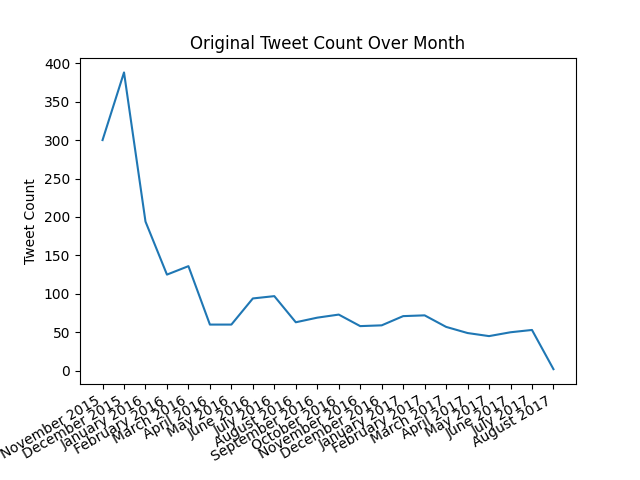

In [1035]:
temp = master_df['timestamp'][master_df['is_original']]
time_ser = pd.Series(data=(temp.dt.month_name().astype('string') + ' ' + temp.dt.year.astype('string')))
data = time_ser.value_counts().sort_values(key=lambda item: pd.to_datetime(item.index))
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(data)
ax.set_ylabel('Tweet Count')
ax.set_title('Original Tweet Count Over Month')
plt.show()

### Visualization #2: Distribution of original tweets' favorite count

- Include only original tweets: `master_df['favorite_count'][(master_df['is_original']) & (master_df['favorite_count'].notna())]`
- plot a histogram for the given series
- limit by a certain percentile.

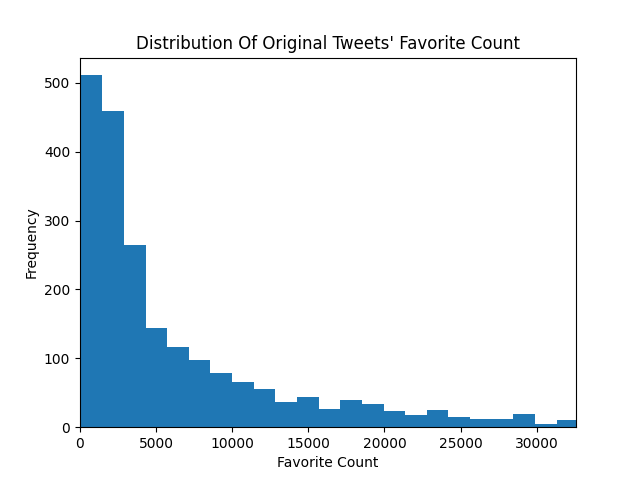

In [1034]:
temp = master_df['favorite_count'][(master_df['is_original']) & (master_df['favorite_count'].notna())]
fig, ax = plt.subplots()
ax.hist(x=temp, bins=100)
ax.set_title('Distribution Of Original Tweets\' Favorite Count')
ax.set_xlim(left=0, right=temp.quantile(0.975))
ax.set_ylabel('Frequency')
ax.set_xlabel('Favorite Count')
plt.show()